Final Project SDA

System prognozowania rekomendacji restauracji oraz analiza grup konsumenckich

Created by: Joanna Zawadzka, Patryk Zieliński

August 2023

ETAP 1:

Import bibliotek

In [1]:
# Data Analysis Libraries
import pandas as pd
import numpy as np
from scipy.stats import shapiro

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Machine Learning Libraries
import sklearn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#Hyperparameter Optimization
from hyperopt import fmin, tpe, hp

ETAP 2:

Opis datasetu

Kolumny:


*   Restaurant_Name - nazwa restauracji
*   Dining_Rating - średnia ocena lokalu na podstawie serwowanych klientom potraw
*   Delivery_Rating - średnia ocena dostawy na podstawie jakości realizowanych usług
*   Dining_Votes - liczba głosów / ocen oddanych na dany lokal przez klientów
*   Delivery_Votes - liczba głosów / ocen oddanych w ramach oceny dostawy
*   Cuisine - typ restauracji
*   Place_Name - dzielnica miasta, w której zlokalizowany jest lokal
*   City - lokalizacja lokalu (miasto)
*   Item_Name - danie oferowane w danym lokalu
*   Best_Seller - opisuje, czy oferowane danie w kolumnie "Item_Name" jest często zamawiane wg wskaźników oceny:
*   Votes - liczba głosów oddanych na danie z kolumny "Item_Name"
*   Prices - cena dania

In [2]:
#potrzebne funkcje
#statystyki opisowe
#OPCJONALNIE: zobaczyć, czy można to przerobić na zasadzie słownika
def describe_data(dataframe, columns):
    statistics = {
        'Minimum': [],
        'Maximum': [],
        'Mean': [],
        'Median': [],
        'Variance': [],
        'Skewness': [],
        '25th Percentile': [],
        '75th Percentile': [],
        'Kurtosis': [],
        'Standard Deviation': [],
        'Coefficient of Variation': []
    }

    for col in columns:
        statistics['Minimum'].append(dataframe[col].min())
        statistics['Maximum'].append(dataframe[col].max())
        statistics['Mean'].append(dataframe[col].mean())
        statistics['Median'].append(dataframe[col].median())
        statistics['Variance'].append(dataframe[col].var())
        statistics['Skewness'].append(dataframe[col].skew())
        statistics['25th Percentile'].append(np.percentile(dataframe[col], 25))
        statistics['75th Percentile'].append(np.percentile(dataframe[col], 75))
        statistics['Kurtosis'].append(dataframe[col].kurtosis())
        statistics['Standard Deviation'].append(dataframe[col].std())
        statistics['Coefficient of Variation'].append((dataframe[col].std() / dataframe[col].mean()))

    statistics_df = pd.DataFrame(statistics)
    return statistics_df

In [3]:
#funkcja do tworzenia wykresów słupkowych
def draw_barplot(data, title, xlabel, ylabel):
    """
    Create and display a bar plot using Seaborn.

    Parameters:
        data (pd.DataFrame): The dataset to be plotted.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize = (8,8))
    sns.barplot(x = data.index, y = data.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 90)
    plt.show()

In [4]:
#funkcja do tworzenia wykresu actual vs predict
def compare_actual_predict(y_pred, y_test, title, x_label, y_label):
    """
    Create a scatter plot to compare actual values with predicted values.

    Parameters:
        y_pred (array-like): Predicted values.
        y_test (array-like): Actual (true) values.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.

    Returns:
        None
    """
    fig, ax = plt.subplots(figsize = (8,8))
    sns.scatterplot(x = y_pred, y = y_test)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [5]:
#funkcja do kalkulacji MAPE
#MAPE informuje o średniej wielkości błędów prognoz dla zbioru testowego
def calc_mape(y, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

    MAPE measures the percentage difference between predicted and actual values.
    It is commonly used to evaluate the accuracy of predictive models.

    Parameters:
        y (array-like): Actual (true) values.
        y_pred (array-like): Predicted values.

    Returns:
        float: Mean Absolute Percentage Error (MAPE) value.
    """
    nominator = np.sum(np.abs((y - y_pred) / y))
    denominator = len(y)
    return nominator / denominator

In [35]:
def objective(params):
    """
    Objective function for hyperparameter optimization using cross-validation.

    This function creates an ElasticNet model with specified hyperparameters,
    fits it on the training data, and calculates the negative mean squared error
    (MSE) using cross-validation as the evaluation metric. The goal is to find
    the hyperparameters that minimize this metric.

    Parameters:
        params (dict): Dictionary containing hyperparameters.
            - 'alpha' (float): Regularization parameter.
            - 'l1_ratio' (float): Mixing parameter for L1 and L2 regularization.

    Returns:
        float: Mean of the negative MSE scores across cross-validation folds.
    """
    alpha = params['alpha']
    l1_ratio = params['l1_ratio']

    # Create an ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    # Load or prepare your data
    X, y = X_train_scaled, y_train

    # Calculate cross-validation score using negative mean squared error
    mse_scores = -cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

    # Return the mean of the negative MSE scores
    return np.mean(mse_scores)

ETAP 3:

Import i przygotowanie danych

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/getry28/SDA_Final/main/zomato_dataset.csv')
df.head(10)

,Restaurant_Name,Dining_Rating,Delivery_Rating,Dining Votes,Delivery_Votes,Cuisine,Place_Name,City,Item_Name,Best_Seller,Votes,Prices
0,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Platter Kebab Combo,BESTSELLER,84,249.0
1,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Rumali Shawarma,BESTSELLER,45,129.0
2,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Tandoori Salad,NaN,39,189.0
3,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken BBQ Salad,BESTSELLER,43,189.0
4,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Special Doner Wrap Combo,MUST TRY,31,205.0
5,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Tandoori Pizza [8 inches],BESTSELLER,48,199.0
6,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Special Zinger Tortilla Wrap,CHEF'S SPECIAL,27,165.0
7,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Popcorn [20 Pieces],BESTSELLER,59,165.0
8,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Tandoori Sandwich,NaN,29,115.0
9,Doner King,3.9,4.2,39,0,Fast Food,Malakpet,Hyderabad,Chicken Bread Samoli Shawarma,NaN,31,129.0


In [7]:
#charakterystyka danych
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123657 entries, 0 to 123656
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Restaurant_Name  123657 non-null  object 
 1   Dining_Rating    91421 non-null   float64
 2   Delivery_Rating  122377 non-null  float64
 3   Dining Votes     123657 non-null  int64  
 4   Delivery_Votes   123657 non-null  int64  
 5   Cuisine          123657 non-null  object 
 6   Place_Name       123657 non-null  object 
 7   City             123657 non-null  object 
 8   Item_Name        123657 non-null  object 
 9   Best_Seller      27942 non-null   object 
 10  Votes            123657 non-null  int64  
 11  Prices           123657 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 11.3+ MB


In [8]:
#sprawdzenie braków danych
df.isnull().sum()

Restaurant_Name        0
Dining_Rating      32236
Delivery_Rating     1280
Dining Votes           0
Delivery_Votes         0
Cuisine                0
Place_Name             0
City                   0
Item_Name              0
Best_Seller        95715
Votes                  0
Prices                 0
dtype: int64

In [9]:
#wywalenie braków w kolumnie Dining_Rating
df = df[df['Dining_Rating']>1]
df.isnull().sum()

Restaurant_Name        0
Dining_Rating          0
Delivery_Rating       61
Dining Votes           0
Delivery_Votes         0
Cuisine                0
Place_Name             0
City                   0
Item_Name              0
Best_Seller        71193
Votes                  0
Prices                 0
dtype: int64

In [10]:
#podział zmiennych
X = df[['Delivery_Rating','Dining Votes', 'Delivery_Votes', 'Best_Seller' ,'Votes', 'Prices']]
y = df['Dining_Rating']

In [11]:
#podział danych na treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [12]:
#selekcja kolumn kategorycznych
cat_cols = X_train.select_dtypes(include = ['object']).columns.tolist()
num_cols = ['Delivery_Rating']

In [13]:
#pipeline oraz OHE
X_train_missing_data = X_train[['Delivery_Rating','Best_Seller']]
X_test_missing_data = X_test[['Delivery_Rating','Best_Seller']]

cat_pipe = make_pipeline(
    SimpleImputer (strategy = 'constant', fill_value = 'NONE'),
    OneHotEncoder(sparse_output = False)
)

num_pipe = make_pipeline(
    SimpleImputer(strategy = 'most_frequent')
)

preprocessor = ColumnTransformer(transformers = [
    ('cat_pipe', cat_pipe, cat_cols),
    ('num_pipe', num_pipe, num_cols)
])

preprocessor.fit(X_train_missing_data)
X_train_missing_data = preprocessor.transform(X_train_missing_data)
X_test_missing_data = preprocessor.transform(X_test_missing_data)

In [14]:
#łączenie danych po obróbce
X_train['Delivery_Rating'] = X_train_missing_data[:,-1]
X_test['Delivery_Rating'] = X_test_missing_data[:,-1]

X_train = X_train.drop('Best_Seller',axis = 1)
X_test = X_test.drop('Best_Seller',axis = 1)

new_cols = ['Sold_As_BESTSELLER', "Sold_As_CHEFS SPECIAL", 'Sold_As_DAIRY FREE', 'Sold_As_Eggless available', 'Sold_As_FODMAP FRIENDLY',
        'Sold_As_GLUTEN FREE', 'Sold_As_MUST TRY', 'Sold_As_NEW', 'Sold_As_Not eligible for coupons', 'Sold_As_Not on Pro', 'Sold_As_SEASONAL',
        'Sold_As_SPICY', 'Sold_As_VEGAN', 'NONE']

for i in range(14):
  X_train[new_cols[i]] = X_train_missing_data[:,i]
  X_test[new_cols[i]] = X_test_missing_data[:,i]

ETAP 4:

EDA + wizualizacja danych

In [15]:
selected_columns = ['Delivery_Rating', 'Dining_Rating', 'Dining Votes', 'Delivery_Votes', 'Votes', 'Prices']
statistics_result = describe_data(df, selected_columns)

In [16]:
# Zamiana indeksów 0 i 1 na etykiety wybranych kolumn
statistics_result.index = selected_columns

# Wyświetlenie wyników
print(statistics_result)

                 Minimum  Maximum        Mean  Median      Variance  \
Delivery_Rating     3.00      4.6    3.970807     4.0      0.055009   
Dining_Rating       2.50      4.8    3.822264     3.9      0.167030   
Dining Votes        0.00    997.0  206.542053   105.0  61829.230098   
Delivery_Votes      0.00    983.0   86.908992     0.0  49449.154002   
Votes               0.00   9750.0   28.013651     0.0  19900.685025   
Prices              0.95  12024.0  239.984147   209.0  34889.364663   

                  Skewness  25th Percentile  75th Percentile     Kurtosis  \
Delivery_Rating  -0.433628              NaN              NaN    -0.102312   
Dining_Rating    -0.606871             3.60              4.1     0.039508   
Dining Votes      1.402051            15.00            319.0     1.051914   
Delivery_Votes    2.624857             0.00              0.0     5.790195   
Votes            30.299213             0.00             17.0  1526.232262   
Prices            7.920016           133

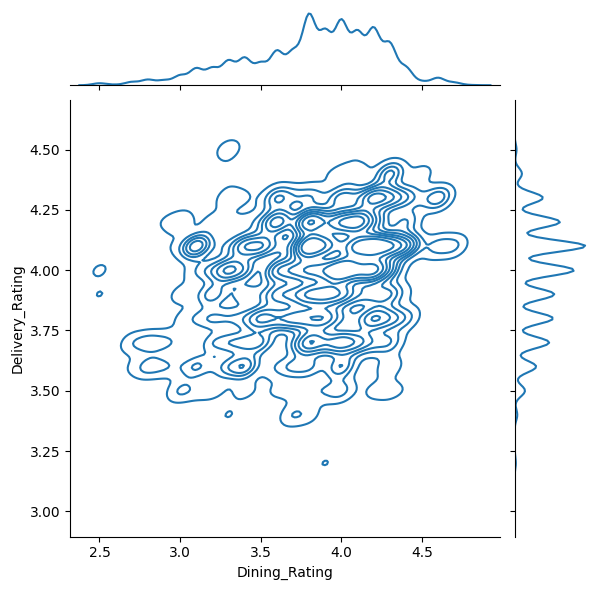

In [17]:
#zależności pomiędzy Dining_Rating a Delivery_Rating
plt.figsize = (8,8)
sns.jointplot(data = df, x = 'Dining_Rating', y = 'Delivery_Rating', kind = 'kde')
plt.show()

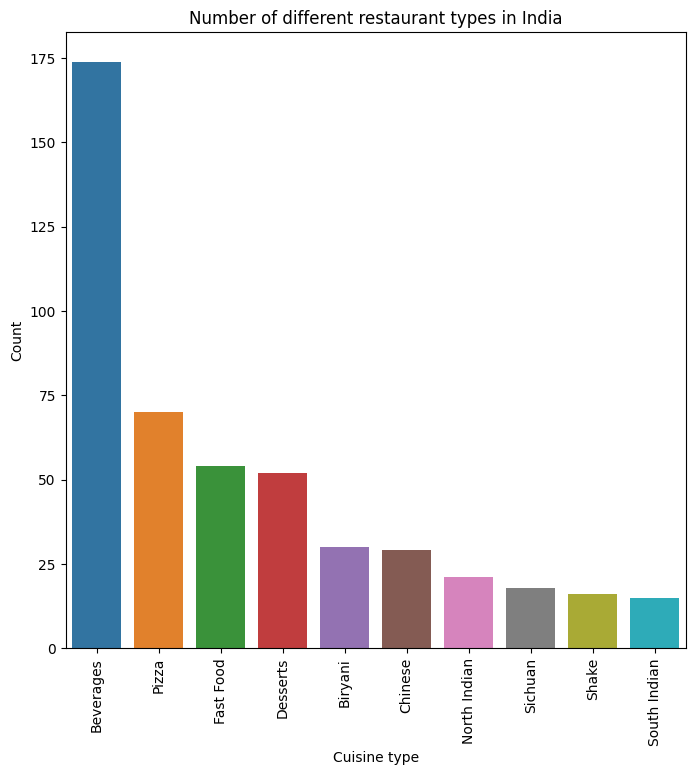

In [18]:
#typy restauracji
cuisine_grouped = df[['Restaurant_Name', 'Cuisine ']].value_counts().reset_index(name='count').drop('count', axis = 1).groupby('Cuisine ')['Cuisine '].count().nlargest(10)
draw_barplot(cuisine_grouped, "Number of different restaurant types in India", 'Cuisine type', 'Count')

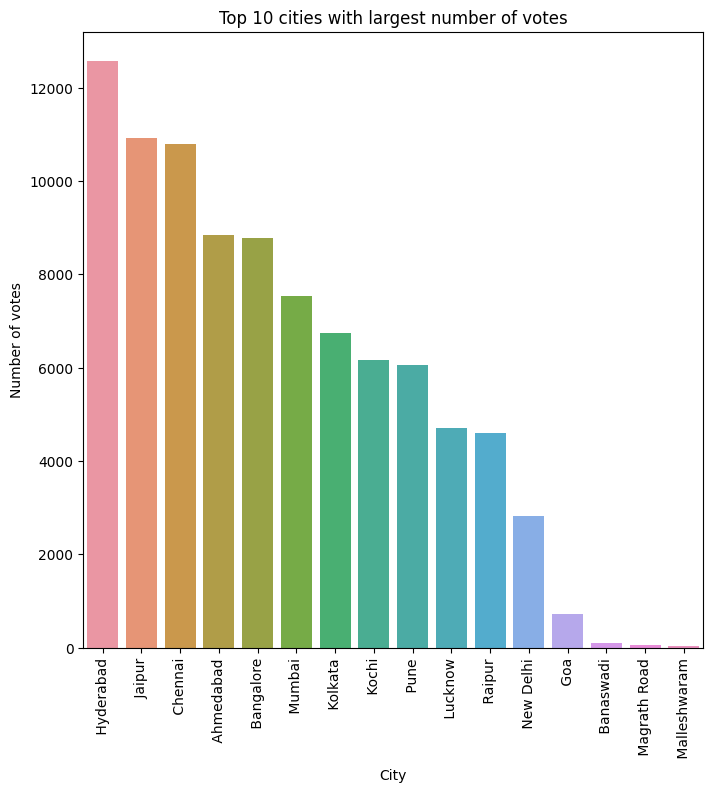

In [19]:
#TOP 10 miast, w których oddano najwięcej głosów
city_count = df['City'].value_counts()
draw_barplot(city_count, "Top 10 cities with largest number of votes", 'City', "Number of votes")

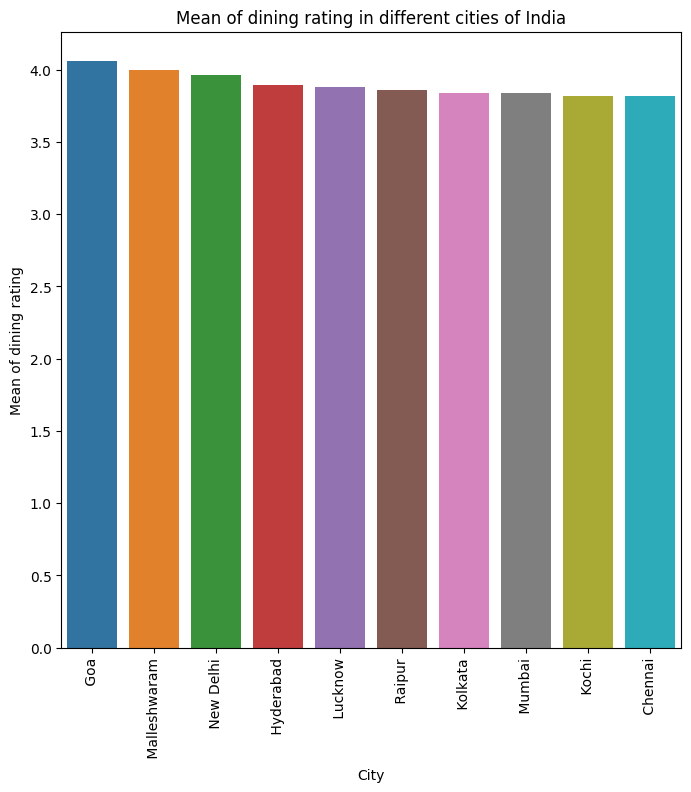

In [20]:
#średnia dla oceny zamówionej potrawy wg miasta
sorted_cities = df.groupby('City')['Dining_Rating'].mean().nlargest(10)
draw_barplot(sorted_cities, "Mean of dining rating in different cities of India", 'City', "Mean of dining rating")

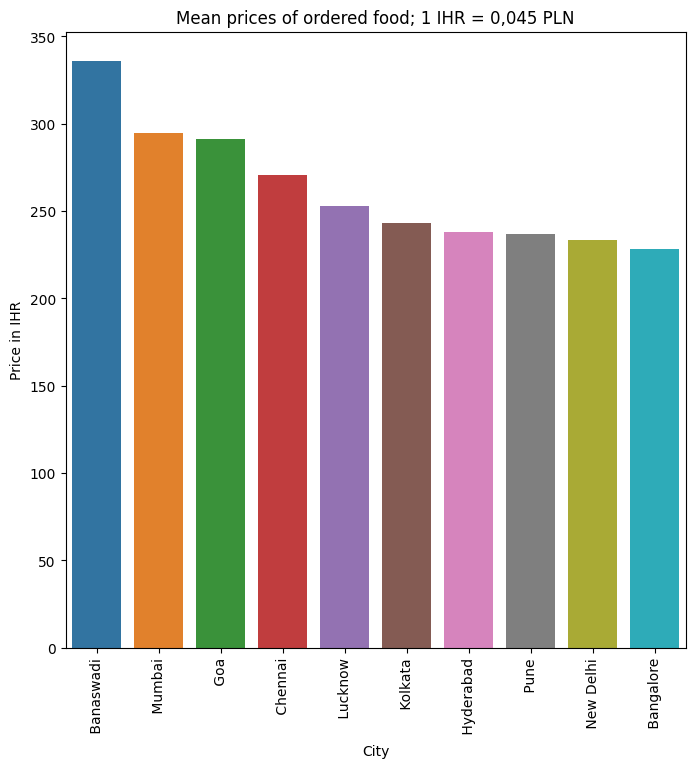

In [21]:
#ceny potraw w miastach
price_cities = df.groupby('City')['Prices'].mean().nlargest(10)
draw_barplot(price_cities, 'Mean prices of ordered food; 1 IHR = 0,045 PLN', 'City', 'Price in IHR')

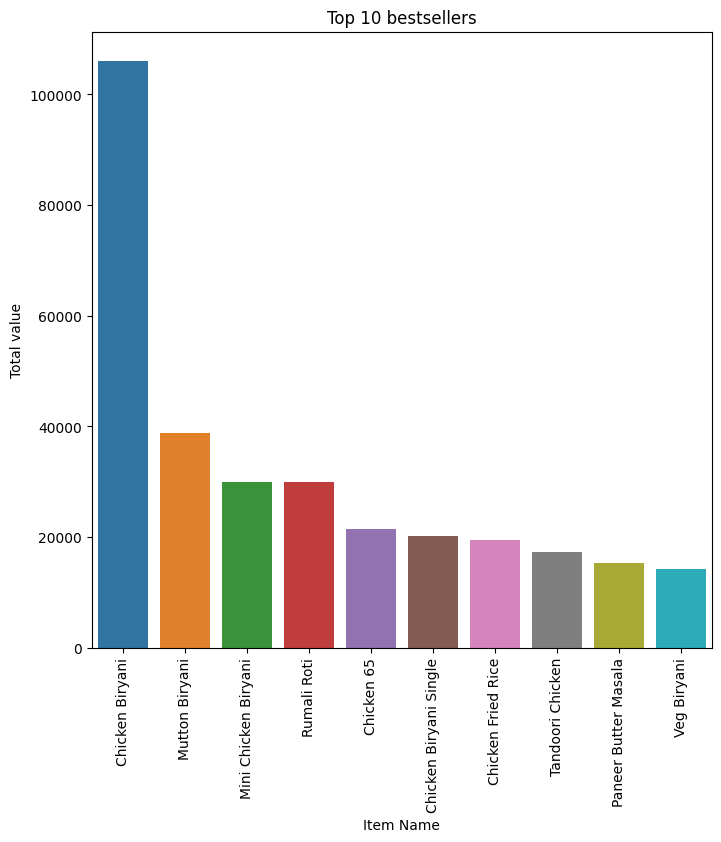

In [22]:
#co się najlepiej sprzedaje
best_sellers = df.groupby('Item_Name')['Votes'].sum().nlargest(10)
draw_barplot(best_sellers, 'Top 10 bestsellers','Item Name', 'Total value')

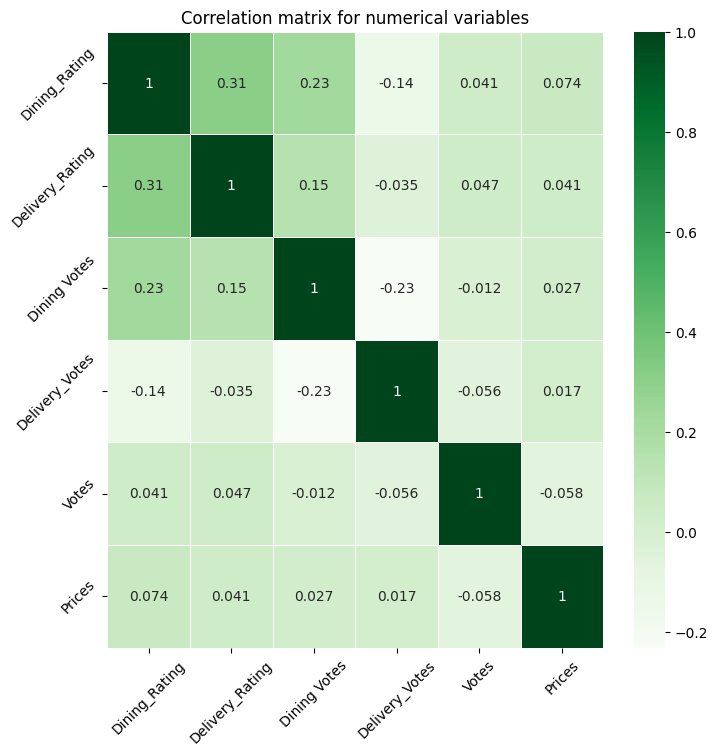

In [23]:
#macierz korelacji zmiennych numerycznych
fig, ax = plt.subplots(figsize = (8,8))
sns.heatmap(round(df[['Dining_Rating', 'Delivery_Rating', 'Dining Votes', 'Delivery_Votes', 'Votes', 'Prices']].corr(),3), annot = True, cmap = 'Greens', linewidth = 0.5)
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.title("Correlation matrix for numerical variables")
plt.show()

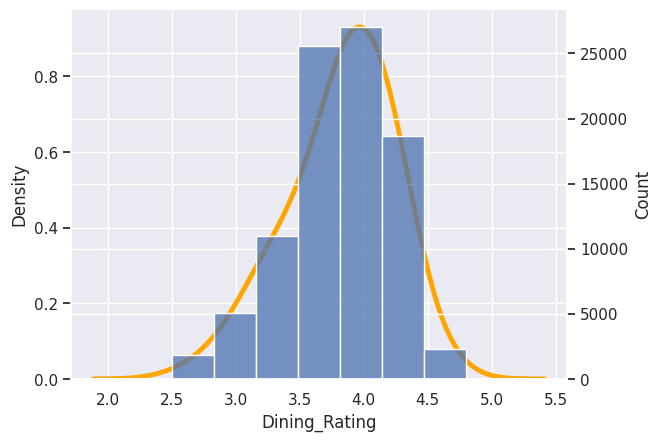

<Figure size 800x800 with 0 Axes>

In [24]:
#wykres rozkladu zmiennej zależnej
sns.set(style = 'darkgrid')
fig, ax1 = plt.subplots()
plt.figure(figsize = (8,8))

ax2 = ax1.twinx()
sns.histplot(data = df,
             x = 'Dining_Rating',
            bins = 7, ax = ax2)
sns.kdeplot(data = df, x='Dining_Rating', ax = ax1, linewidth = 3.5, color='orange', bw_method = 0.5)
plt.show()

In [25]:
#test na normalność rozkładu zmiennej zależnej
stat, p = shapiro(df['Dining_Rating'])
print('Statistics = %.3f, p = %.3f' % (stat, p))
if p < 0.05:
  print("H0 rejected - sample does not look Gaussian")
else:
  print("Fail to reject H0 - sample looks Gaussian")

Statistics = 0.966, p = 0.000
H0 rejected - sample does not look Gaussian


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ETAP 5:

Wybrane modele ML regresji liniowej

In [26]:
#basicowe drzewo decyzyjne
tree_reg = DecisionTreeRegressor(max_depth = 3)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

[Text(0.5, 0.875, 'x[1] <= 0.5\nsquared_error = 0.167\nsamples = 73136\nvalue = 3.822'),
 Text(0.25, 0.625, 'x[2] <= 9.5\nsquared_error = 0.107\nsamples = 9790\nvalue = 4.131'),
 Text(0.125, 0.375, 'x[0] <= 4.25\nsquared_error = 0.068\nsamples = 8771\nvalue = 4.194'),
 Text(0.0625, 0.125, 'squared_error = 0.063\nsamples = 6941\nvalue = 4.135'),
 Text(0.1875, 0.125, 'squared_error = 0.025\nsamples = 1830\nvalue = 4.417'),
 Text(0.375, 0.375, 'x[0] <= 4.25\nsquared_error = 0.117\nsamples = 1019\nvalue = 3.592'),
 Text(0.3125, 0.125, 'squared_error = 0.113\nsamples = 958\nvalue = 3.566'),
 Text(0.4375, 0.125, 'squared_error = -0.0\nsamples = 61\nvalue = 4.0'),
 Text(0.75, 0.625, 'x[1] <= 98.5\nsquared_error = 0.159\nsamples = 63346\nvalue = 3.775'),
 Text(0.625, 0.375, 'x[1] <= 18.5\nsquared_error = 0.158\nsamples = 25305\nvalue = 3.552'),
 Text(0.5625, 0.125, 'squared_error = 0.132\nsamples = 10134\nvalue = 3.444'),
 Text(0.6875, 0.125, 'squared_error = 0.162\nsamples = 15171\nvalue = 3.

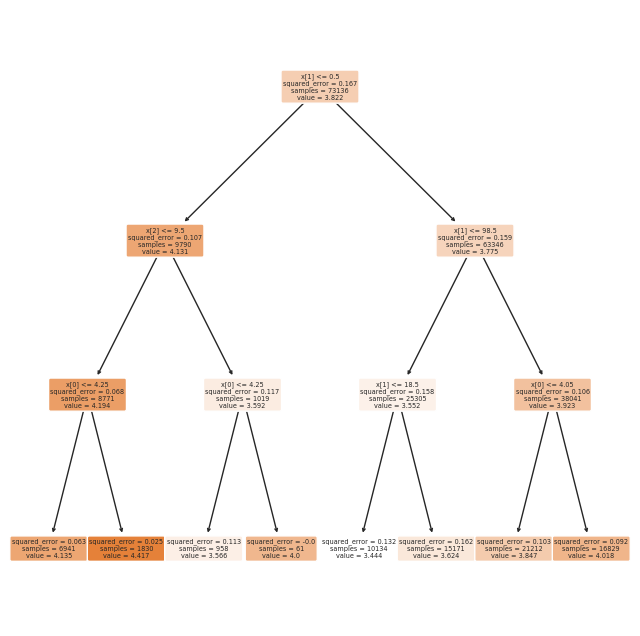

In [27]:
#wyrkes drzewa decyzyjnego
plt.figure(figsize = (8,8))
sklearn.tree.plot_tree(tree_reg,
                       filled = True, rounded = True)

In [28]:
#podział zbioru treningowego na treningowy i walidacyjny
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)
#0.25 dlatego, żeby mieć 20% danych z całego datasetu
#20% tutaj = 16% danych z datasetu

In [30]:
#skalowanie
scl = StandardScaler()
columns_to_scale = ['Delivery_Rating', 'Dining Votes', 'Delivery_Votes', 'Votes', 'Prices']
X_train_scaled = X_train[:]
X_test_scaled = X_test[:]
X_train_scaled[columns_to_scale] = scl.fit_transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scl.fit_transform(X_test_scaled[columns_to_scale])

In [31]:
summary_table = pd.DataFrame()

#wybór optymalnej głębokości drzewa decyzyjnego na podstawie 10-krotnej cross-walidacji
for i in tqdm(np.arange(1,31)):
  tree = DecisionTreeRegressor(max_depth = i)
  val_mse = np.abs(np.mean(cross_val_score(tree, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = -1)))
  tree.fit(X_train, y_train)
  train_pred = tree.predict(X_train)
  train_mse = mean_squared_error(y_train, train_pred)

  summary_table = pd.concat([summary_table,
                              pd.DataFrame({'depth':[i],
                                            'train_mse':[train_mse],
                                            'val_mse':[val_mse]})])

100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


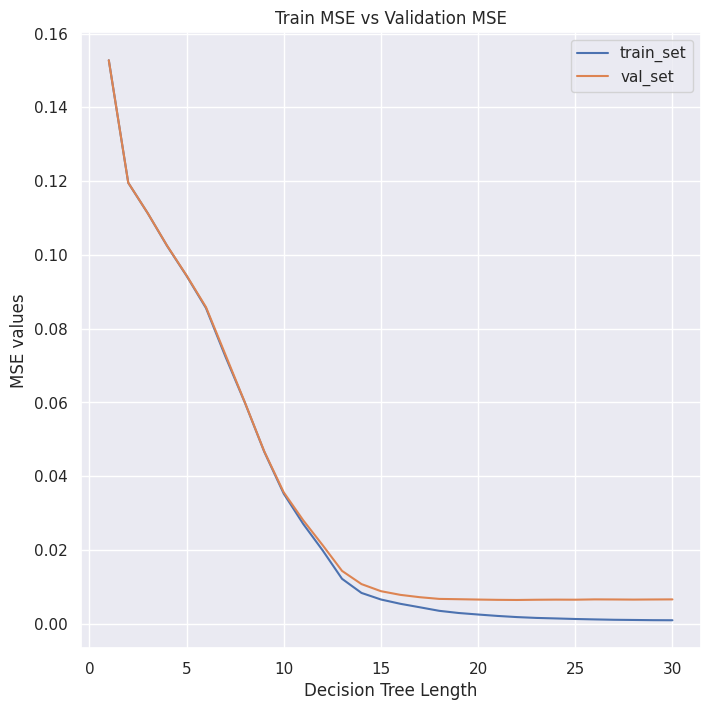

In [32]:
agg_table = summary_table.groupby('depth').agg(train_mse = ('train_mse','mean'),
                                               val_mse = ('val_mse','mean'))

plt.figure(figsize = (8,8))
sns.lineplot(data = agg_table, x = 'depth', y = 'train_mse', label = 'train_set')
sns.lineplot(data = agg_table, x = 'depth', y = 'val_mse', label = 'val_set')
plt.xlabel('Decision Tree Length')
plt.ylabel('MSE values')
plt.title('Train MSE vs Validation MSE')
plt.legend()
plt.show()

In [36]:
#strojenie hiperparametrów do ElasticNet za pomocą hyperopt
space = {
    'alpha': hp.loguniform('alpha', -6, 2),
    'l1_ratio': hp.uniform('l1_ratio', 0, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)  # Number of evaluations

print("Best hyperparameters:", best)

100%|██████████| 100/100 [00:39<00:00,  2.52trial/s, best loss: 0.1428343578406151]
Best hyperparameters: {'alpha': 0.0025860963663550045, 'l1_ratio': 0.026427917061496095}


In [37]:
#pobranie parametrów pod ElasticNet z hyperopt
best_alpha = best['alpha']
best_l1_ratio = best['l1_ratio']

ETAP 6:

Ocena wybranych modeli regresji liniowej

In [39]:
#najlepsze drzewo regresyjne
best_tree = DecisionTreeRegressor(max_depth = 18)
best_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=18)

In [40]:
y_pred_tree = best_tree.predict(X_test)

In [ ]:
#MAPE dla drzewa decyzyjnego
print("{:.2f}".format(calc_mape(y_test, y_pred_tree)*100)+"%")

0.50%


In [ ]:
#MAE dla drzewa regresyjnego
mean_absolute_error(y_test, y_pred_tree)

0.01916735116795239

In [ ]:
#MSE dla drzewa decyzyjnego
mean_squared_error(y_test, y_pred_tree)

0.006995516636695434

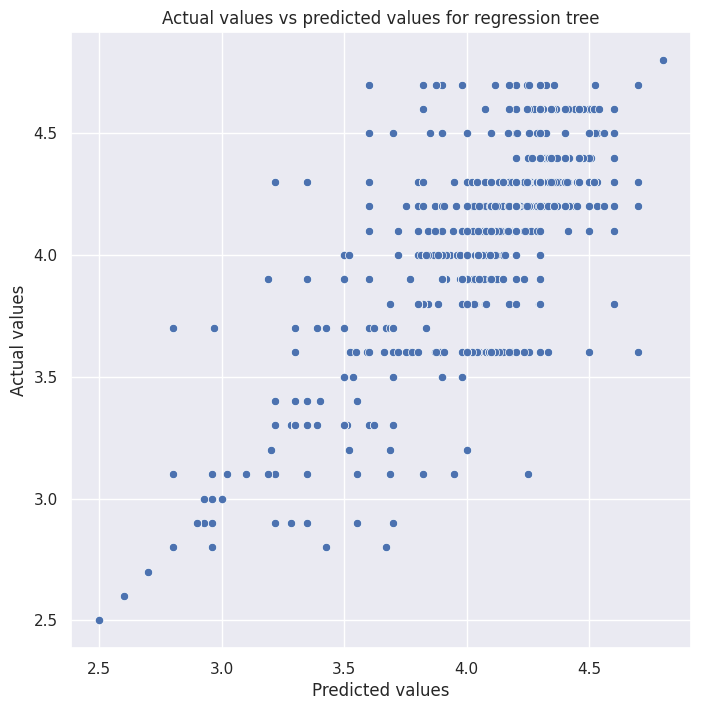

In [ ]:
#wykres actual vs predict dla drzewa decyzyjnego
compare_actual_predict(y_pred_tree, y_test, 'Actual values vs predicted values for regression tree', 'Predicted values', 'Actual values')

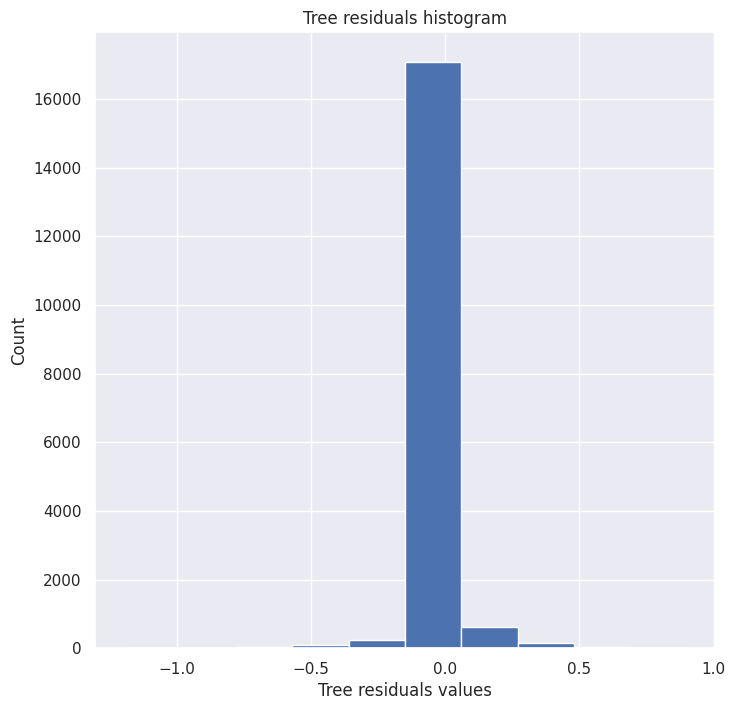

In [54]:
#reszty dla drzewa decyzyjnego
tree_residuals = (y_test - y_pred_tree)

#wykres reszt dla drzewa decyzyjnego
plt.figure(figsize = (8,8))
plt.hist(x = tree_residuals)
plt.xlabel('Tree residuals values')
plt.ylabel('Count')
plt.title('Tree residuals histogram')
plt.show()

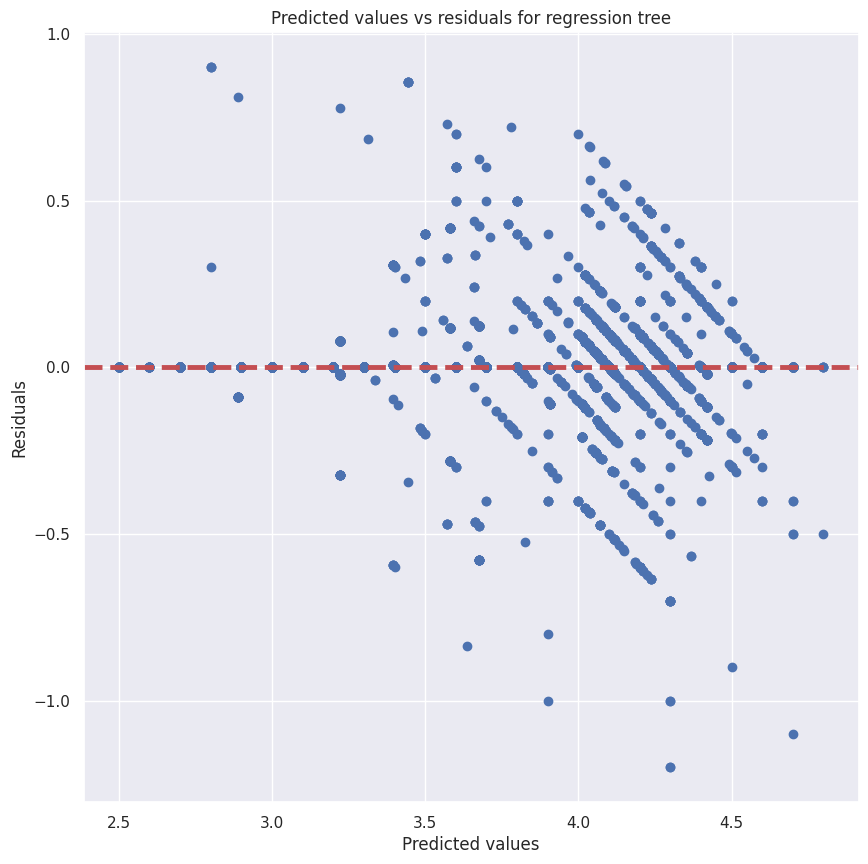

In [63]:
#wykres reszt
plt.figure(figsize = (10,10))
plt.scatter(x = y_pred_tree, y = tree_residuals)
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 3.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values vs residuals for regression tree')
plt.show()

In [42]:
#regresja ElasticNet z wykorzystaniem hiperparametrów uzyskanych za pomocą hyperopt
reg_net = ElasticNet(alpha = best_alpha, l1_ratio = best_l1_ratio)
reg_net.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.0025860963663550045, l1_ratio=0.026427917061496095)

In [43]:
y_pred_net = reg_net.predict(X_test_scaled)

In [44]:
y_pred_net

array([3.7036966 , 3.47057038, 3.95117923, ..., 3.92453472, 3.81576088,
       3.68991064])

In [45]:
#MAPE dla elastic net
print("{:.2f}".format(calc_mape(y_test, y_pred_net)*100)+"%")

8.35%


In [ ]:
#MSE dla elastic net
mean_squared_error(y_pred_net, y_test)

0.14012109317843693

In [ ]:
#MAE dla elastic net
mean_absolute_error(y_pred_net, y_test)

0.30017599952763924

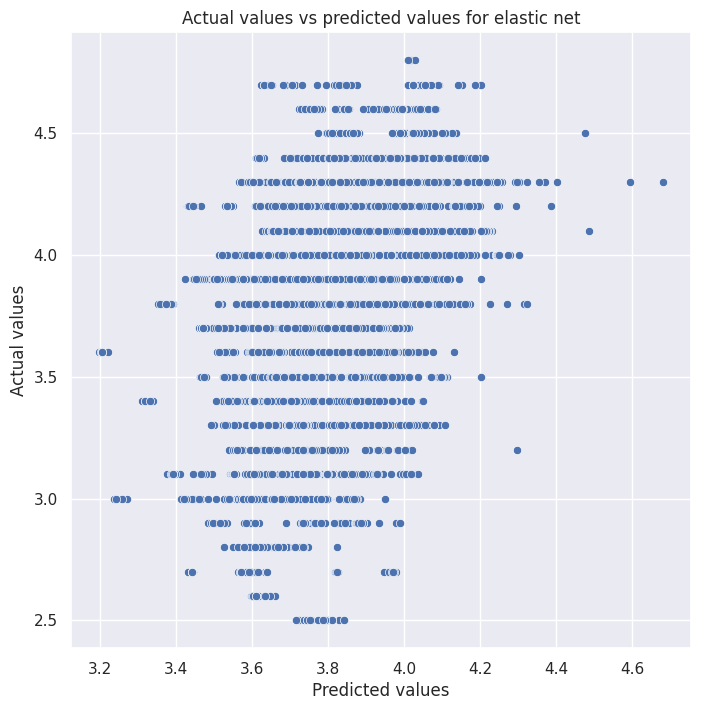

In [46]:
#wykres actual vs predict
compare_actual_predict(y_pred_net, y_test, 'Actual values vs predicted values for elastic net', 'Predicted values', 'Actual values')

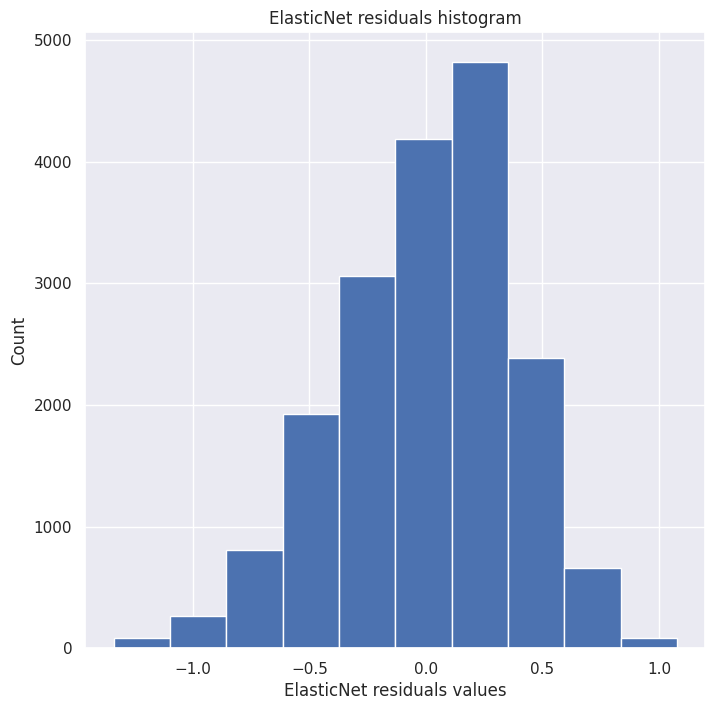

In [48]:
#reszty dla modelu siatki
net_residuals = (y_test - y_pred_net)

plt.figure(figsize = (8,8))
plt.hist(x = net_residuals)
plt.xlabel('ElasticNet residuals values')
plt.ylabel('Count')
plt.title('ElasticNet residuals histogram')
plt.show()

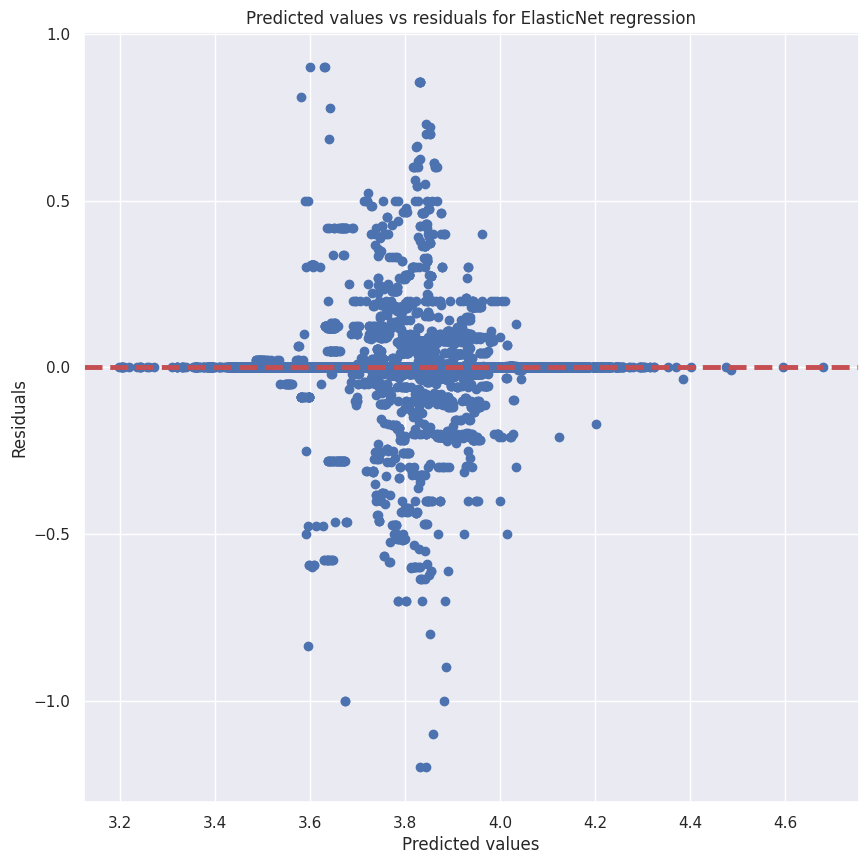

In [64]:
#wykres reszt
plt.figure(figsize = (10,10))
plt.scatter(x = y_pred_net, y = tree_residuals)
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 3.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values vs residuals for ElasticNet regression')
plt.show()